# K-Means & DBSCAN Clustering

In [1]:
random_state = 41

1. Retrieve and load the Olivetti faces dataset

In [2]:
from sklearn.datasets import fetch_olivetti_faces

# Load the dataset
faces = fetch_olivetti_faces()
X = faces.data
y = faces.target

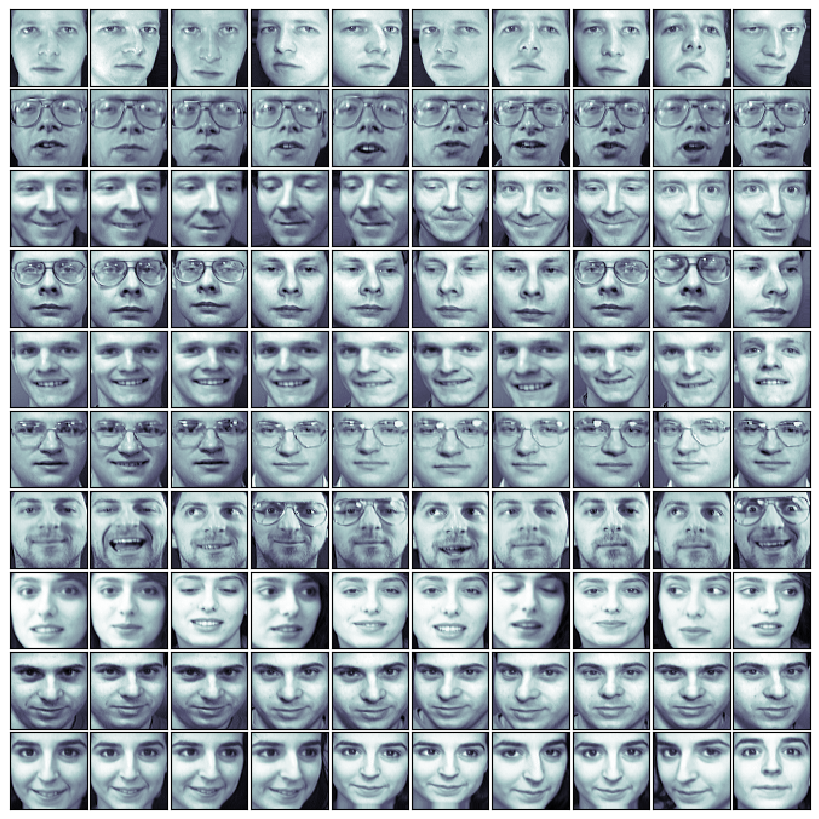

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(X[i].reshape(64,64), cmap=plt.cm.bone, interpolation='nearest')
plt.show()

2. Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set.

Data is split into 60% training, 20% validation, and 20% testing. This helps in building a robust model while keeping enough data for evaluation.

In [4]:
from sklearn.model_selection import train_test_split

# First, split into training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=random_state)

# Then, split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)

3. Using k-fold cross validation, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

classifier = SVC(kernel='linear')
scores = cross_val_score(classifier, X_train, y_train)
mean_score = scores.mean()
print(f"Mean CV Score: {mean_score}")

# Train the classifier on the entire training set
classifier.fit(X_train, y_train)

# Evaluate on the validation set
val_score = classifier.score(X_val, y_val)
print(f"Validation Set Score: {val_score}")

Mean CV Score: 0.9541666666666666
Validation Set Score: 0.9375


4. Use K-Means to reduce the dimensionality of the set. Use the silhouette score approach to choose the number of clusters.

Euclidean distance is used as the similarity measure since facial images often share spatial relationships.

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Finding the optimal number of clusters
silhouette_scores = []
k_range = range(5, 150, 5)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(X_train)
    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_scores.append(score)

# Choose the best k based on maximum silhouette score
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Best K: {best_k}")

Best K: 80


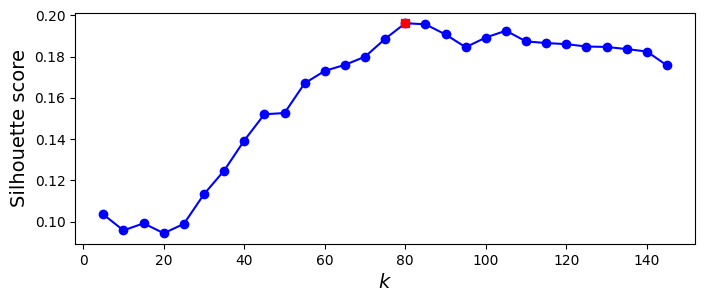

In [7]:
import numpy as np
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

5. Use the set from step (4) to train a classifier as in step (3)

In [8]:
# Using the best_k from KMeans to cluster the data
kmeans = KMeans(n_clusters=best_k)
X_reduced = kmeans.fit_transform(X_train)

# Train the classifier on the reduced feature set
classifier.fit(X_reduced, y_train)

# Validate the classifier
X_val_reduced = kmeans.transform(X_val)
val_score_reduced = classifier.score(X_val_reduced, y_val)
print(f"Validation Score after K-Means: {val_score_reduced}")

Validation Score after K-Means: 0.9


6. Apply DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm to the Olivetti Faces dataset for clustering. Preprocess the images and convert them into feature vectors, then use DBSCAN to group similar images together based on their density.

Euclidean distance is used as the similarity measure since facial images often share spatial relationships.

Cluster 0


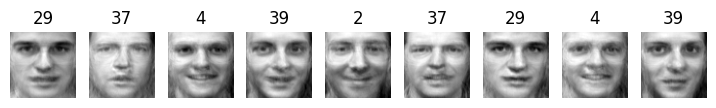

Cluster 1


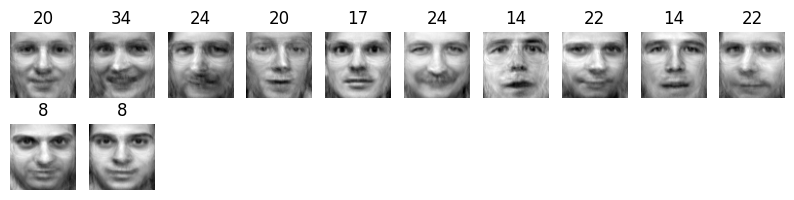

Cluster 2


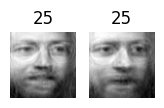

Cluster 3


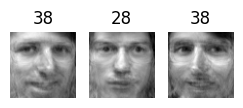

Cluster 4


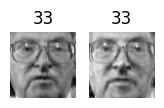

Cluster 5


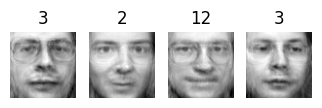

Cluster 6


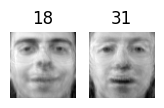

Cluster 7


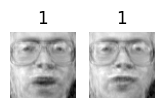

Cluster 8


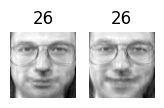

Cluster 9


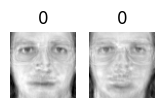

Cluster 10


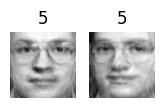

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

#Preserve 95% of training set variance
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_val_reduced = pca.transform(X_val)
X_val_recovered = pca.inverse_transform(X_val_reduced)

# Preprocess images and use DBSCAN
dbscan = DBSCAN(eps=6.55, min_samples=2)
y_val_predict = dbscan.fit_predict(X_val_reduced)

def plot_faces(faces, labels, n_cols=10):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in range(max(y_val_predict)):
    print("Cluster", cluster_id)
    in_cluster = y_val_predict == cluster_id
    faces = X_val_recovered[in_cluster].reshape(-1, 64, 64)
    labels = y_val[in_cluster]
    plot_faces(faces, labels)